In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
from warnings import filterwarnings
import matplotlib.pyplot as plt
filterwarnings('ignore')

In [2]:
genomics = pd.read_csv('C:\\Users\\nilav\\NCI Cell Lines\\nci_genomics.csv', index_col = 0)
genomics.head(2)

,Cell names,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,...,MAFIP,LOC283788,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3
0,BR:MCF7,0.499,1.863,1.137,0.095,-0.356,-0.368,0.120,-0.253,-0.449,...,0.949,-0.028,-0.169,0.935,0.168,0.892,0.090,0.474,-0.201,-0.761
1,BR:MDA-MB-231,-0.386,0.786,0.931,-0.086,-0.508,0.744,-0.364,-0.510,-0.078,...,-1.306,-0.861,-0.169,0.246,-0.207,0.701,-0.293,-0.145,0.185,-0.528


In [3]:
gemc = pd.read_csv('C:\\Users\\nilav\\NCI Cell Lines\\Gemcitabine_NCI.csv')
gemc.drop(columns = ['Unnamed: 0'], inplace=True)
gemc.head(2)

,Cell names,Gemcitabine,cells
0,BR:MDA-MB-231,5.888,MDAMB231
1,BR:HS 578T,5.600,HS578T


In [4]:
working_data = genomics.merge(gemc, on='Cell names')
working_data.shape

(59, 25043)

In [5]:
gemc.shape

(59, 3)

In [6]:
working_data.head(2)

,Cell names,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,...,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3,Gemcitabine,cells
0,BR:MDA-MB-231,-0.386,0.786,0.931,-0.086,-0.508,0.744,-0.364,-0.510,-0.078,...,-0.169,0.246,-0.207,0.701,-0.293,-0.145,0.185,-0.528,5.888,MDAMB231
1,BR:HS 578T,-0.585,0.021,-0.801,-0.795,-0.499,0.720,-1.207,0.098,0.823,...,-0.169,-0.303,-0.268,0.669,-0.246,-1.024,-0.512,-0.172,5.600,HS578T


In [7]:
target = working_data.pop('Gemcitabine')
X = working_data.select_dtypes('float64')

In [8]:
X.head(2)

,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,TUBB8P11,...,MAFIP,LOC283788,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3
0,-0.386,0.786,0.931,-0.086,-0.508,0.744,-0.364,-0.510,-0.078,-0.045,...,-1.306,-0.861,-0.169,0.246,-0.207,0.701,-0.293,-0.145,0.185,-0.528
1,-0.585,0.021,-0.801,-0.795,-0.499,0.720,-1.207,0.098,0.823,1.923,...,-0.920,-0.619,-0.169,-0.303,-0.268,0.669,-0.246,-1.024,-0.512,-0.172


In [9]:
mean = target.mean()
y = []
for i in list(target):
    if i>mean:
        y.append('NR')
    else:
        y.append('R')
y = pd.Series(y)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    31
1    28
dtype: int64

In [11]:
scaler = StandardScaler()
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)

In [12]:
X.head(2)

,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,TUBB8P11,...,MAFIP,LOC283788,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3
0,-0.378306,0.843224,0.969494,-0.090111,-0.514618,0.745022,-0.365166,-0.569089,-0.096179,-0.058416,...,-1.409597,-0.947768,-0.173007,0.281863,-0.204345,0.828610,-0.294187,-0.144175,0.200366,-0.548336
1,-0.577735,0.054258,-0.797510,-0.847027,-0.505608,0.720787,-1.215538,0.085113,0.959963,2.199502,...,-0.987777,-0.681527,-0.173007,-0.309179,-0.266444,0.791586,-0.246095,-1.128775,-0.564902,-0.187441


In [13]:
X.shape, y.shape

((59, 25040), (59,))

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X,y = smote.fit_resample(X,y)

y.value_counts()

1    31
0    31
dtype: int64

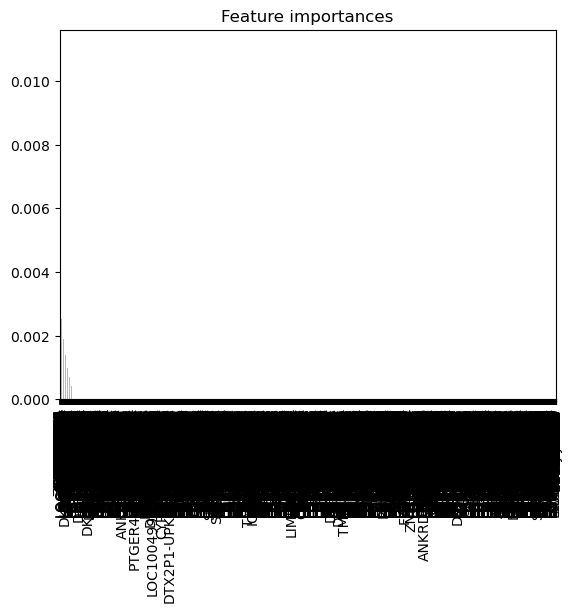

In [15]:
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(class_weight = 'balanced', n_estimators = 150, random_state = 43)
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="lightsalmon", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report

sfm = SelectFromModel(model, threshold = 0.002)
sfm.fit(X,y)

X = pd.DataFrame(data = sfm.transform(X), columns = X.columns[sfm.get_support(1)])
indices = X.index.values
X_train, X_test, train_index, test_index = train_test_split(X,indices, test_size = 0.33, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model.fit(X_train, y_train)
prediction = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print(f'Accuracy on training data: {accuracy_score(y_train, model.predict(X_train))}')
print(f'Accuracy on testing data: {accuracy_score(y_test, model.predict(X_test))}')
print(classification_report(y_test, y_pred))

Accuracy on training data: 1.0
Accuracy on testing data: 0.9047619047619048
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.91      0.91      0.91        11

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



Text(50.722222222222214, 0.5, 'True Labels')

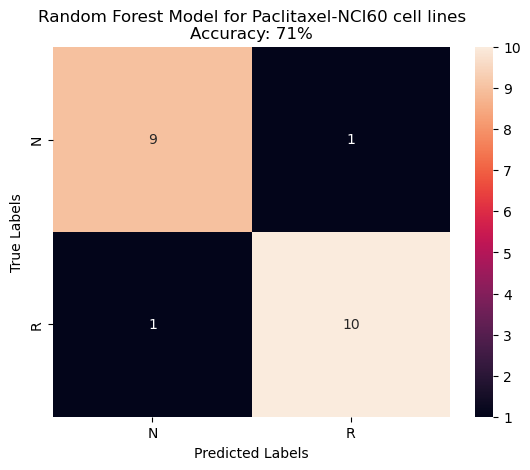

In [17]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'])
ax.set_title('Random Forest Model for Paclitaxel-NCI60 cell lines\nAccuracy: 71%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

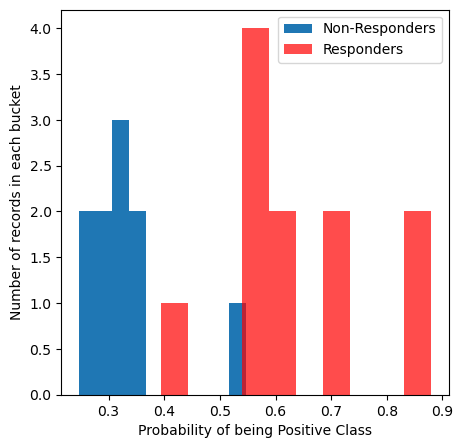

In [18]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders')
plt.hist(prediction[y_test==1], label='Responders', alpha=0.7, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [19]:
responders = prediction[y_test == 1]
count = 0
for i in responders: 
    if i > max(prediction[y_test == 0]):
        count+=1
count, count/len(responders)

(9, 0.8181818181818182)

In [20]:
max(prediction[y_test == 0])

0.5466666666666666

In [21]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction

df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [22]:
df1_main = df1.iloc[:49, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(6, 176)

In [23]:
len(X_train.columns)

175

In [24]:
model2 = SVC(kernel = 'linear', C=1, gamma='auto', probability=True)
model2.fit(X_train, y_train)
prediction2 = model2.predict_proba(X_test)[:, 1]
y_pred = model2.predict(X_test)
print(f'Accuracy on training data: {accuracy_score(y_train, model2.predict(X_train))}')
print(f'Accuracy on testing data: {accuracy_score(y_test, model2.predict(X_test))}')
print(classification_report(y_test, y_pred))

Accuracy on training data: 1.0
Accuracy on testing data: 0.9523809523809523
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.91      0.95        11

    accuracy                           0.95        21
   macro avg       0.95      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21



Text(50.722222222222214, 0.5, 'True labels')

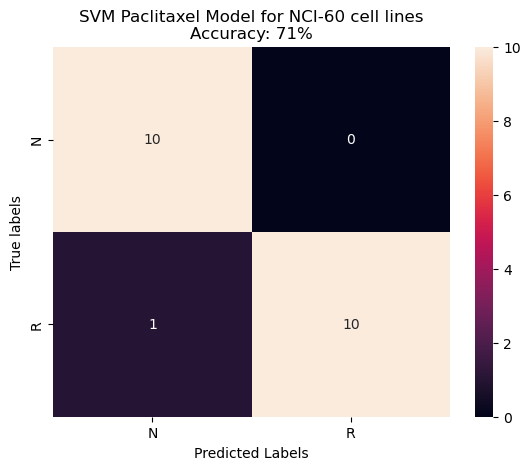

In [25]:
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'])
ax.set_title('SVM Paclitaxel Model for NCI-60 cell lines\nAccuracy: 71%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True labels')

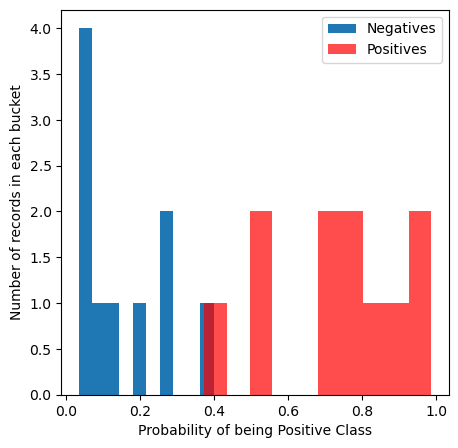

In [26]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives')
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.7, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [27]:
resp_svm = prediction2[y_test == 1]
count = 0
for i in resp_svm:
    if i > max(prediction2[y_test == 0]):
        count+=1
count, count/len(resp_svm)

(10, 0.9090909090909091)

In [28]:
max(prediction2[y_test == 0])

0.39946978015330853

In [29]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2

df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [30]:
df2_main = df2.iloc[:49, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,ESPN,HMGN2P17,NMNAT1,TMEM50A,LPAR3,PIP5K1A,SLC27A3,IQGAP3,INSRR,RPS17P6,...,BCRP8,FBXW4P1,KIAA1671,PLP1,CHRDL1,SOWAHD,TMEM255A,HS6ST2,ND2,test_proba
13,-0.169390,1.043088,0.922537,-0.036573,-0.614892,0.343637,0.906363,-0.429797,-0.555124,-0.798571,...,0.569107,1.258772,1.294728,-0.481084,-0.872374,0.033379,-0.741425,-0.785332,0.216653,0.842407
14,-0.336599,0.885369,-0.935303,0.553060,-0.631341,-0.740424,0.054090,-0.085227,-0.369489,-1.030304,...,1.148148,0.775658,0.395903,-0.565674,-0.767264,-1.138247,-0.688313,-0.771328,-1.219541,0.986990
19,-0.087539,0.958971,0.883737,0.414723,-0.665336,-2.805417,-0.585943,-2.174050,-0.189610,1.116009,...,2.590706,4.354830,-1.451866,-0.447042,-0.562301,0.604677,-0.575584,-0.554806,0.515188,0.696790
26,-0.438328,-0.926304,-1.695328,0.155057,-0.285904,-0.618108,1.152870,1.101508,-0.681758,0.658615,...,-2.661012,-1.575648,0.283411,2.183492,-0.061979,-1.090639,1.817729,-0.875818,0.295321,0.525551
41,-0.474576,-0.965209,0.200171,-1.743107,-0.334155,2.118427,0.093885,-0.654517,-0.509075,-1.339956,...,1.154200,0.274184,0.029468,-0.384116,-0.585425,-0.003779,-0.513800,0.476096,0.129917,0.693818
43,3.906780,0.153549,1.213538,-0.674965,1.599198,0.199735,0.561474,-0.782928,0.692514,0.124314,...,-0.293402,-0.343192,0.632026,-0.544011,0.753671,1.861069,0.018408,-0.147616,-0.689037,0.513734
45,0.225833,-0.790665,-0.602078,-1.087708,-0.512905,0.029451,0.077304,0.305358,-0.029878,0.073717,...,-0.453798,-0.445323,0.208788,-0.614158,0.854577,-0.297556,-0.700236,-0.755169,1.296825,0.769088


In [31]:
model3 = XGBClassifier()
model3.fit(X_train, y_train)
prediction3 = model3.predict_proba(X_test)[:, 1]
y_pred = model3.predict(X_test)

print(f'Accuracy score on training data: {accuracy_score(y_train, model3.predict(X_train))}')
print(f'Accuracy score on testing data: {accuracy_score(y_test, model3.predict(X_test))}')

print(classification_report(y_test, y_pred))

Accuracy score on training data: 1.0
Accuracy score on testing data: 0.8095238095238095
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.89      0.73      0.80        11

    accuracy                           0.81        21
   macro avg       0.82      0.81      0.81        21
weighted avg       0.82      0.81      0.81        21



Text(50.722222222222214, 0.5, 'True Labels')

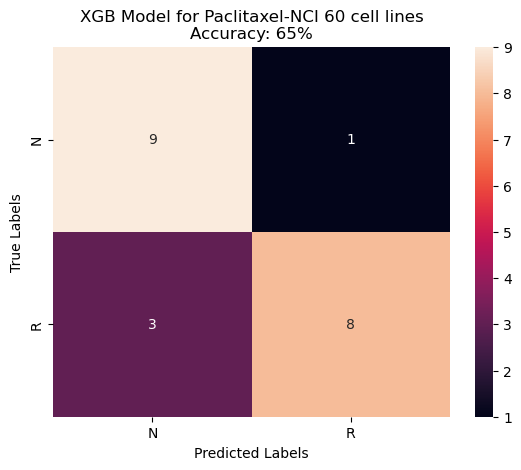

In [32]:
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'])
ax.set_title('XGB Model for Paclitaxel-NCI 60 cell lines\nAccuracy: 65%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

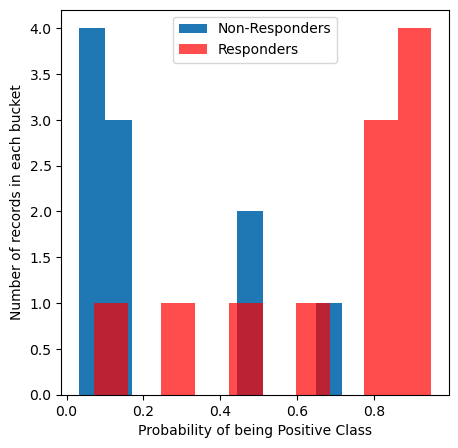

In [33]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders')
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [34]:
resp_xg = prediction3[y_test == 1]
count = 0
for i in resp_xg:
    if i > max(prediction3[y_test == 0]):
        count += 1
count, count/len(resp_xg)

(7, 0.6363636363636364)

In [35]:
max(prediction3[y_test == 0])

0.71746516

In [36]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3

df3 = pd.concat([X_train, df_xg], sort=False).sort_index()

In [37]:
df3_main = df3.iloc[:49, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,ESPN,HMGN2P17,NMNAT1,TMEM50A,LPAR3,PIP5K1A,SLC27A3,IQGAP3,INSRR,RPS17P6,...,BCRP8,FBXW4P1,KIAA1671,PLP1,CHRDL1,SOWAHD,TMEM255A,HS6ST2,ND2,test_proba
13,-0.169390,1.043088,0.922537,-0.036573,-0.614892,0.343637,0.906363,-0.429797,-0.555124,-0.798571,...,0.569107,1.258772,1.294728,-0.481084,-0.872374,0.033379,-0.741425,-0.785332,0.216653,0.851141
14,-0.336599,0.885369,-0.935303,0.553060,-0.631341,-0.740424,0.054090,-0.085227,-0.369489,-1.030304,...,1.148148,0.775658,0.395903,-0.565674,-0.767264,-1.138247,-0.688313,-0.771328,-1.219541,0.874825
26,-0.438328,-0.926304,-1.695328,0.155057,-0.285904,-0.618108,1.152870,1.101508,-0.681758,0.658615,...,-2.661012,-1.575648,0.283411,2.183492,-0.061979,-1.090639,1.817729,-0.875818,0.295321,0.928346
41,-0.474576,-0.965209,0.200171,-1.743107,-0.334155,2.118427,0.093885,-0.654517,-0.509075,-1.339956,...,1.154200,0.274184,0.029468,-0.384116,-0.585425,-0.003779,-0.513800,0.476096,0.129917,0.849761
43,3.906780,0.153549,1.213538,-0.674965,1.599198,0.199735,0.561474,-0.782928,0.692514,0.124314,...,-0.293402,-0.343192,0.632026,-0.544011,0.753671,1.861069,0.018408,-0.147616,-0.689037,0.786987
45,0.225833,-0.790665,-0.602078,-1.087708,-0.512905,0.029451,0.077304,0.305358,-0.029878,0.073717,...,-0.453798,-0.445323,0.208788,-0.614158,0.854577,-0.297556,-0.700236,-0.755169,1.296825,0.873218


In [38]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 21, 1: 20}

In [39]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 10, 1: 11}

In [40]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))
cl = set(common_list)
with open('master_list_genomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')